In [2]:
# import required dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import csv
import seaborn as sns
from IPython.display import set_matplotlib_formats

np.random.seed(0)

set_matplotlib_formats('png', 'pdf') # uses vector figures in pdf exports

plt.style.use('seaborn-pastel')

# load clinical and pathological dataframes with datasets
clin = pd.read_csv('aBeta paper/data/CFAS_ClinicalData.csv',header = 0)

patho = pd.read_excel('aBeta paper/data/CFAS_NeuropathologyData May 2018.xlsx', header = 21)
patho.dropna(subset=['Case'], inplace=True)

clin.rename(columns={'labno':'Case'}, inplace=True)

In [3]:
# declaring functions

def frequencyChart(df,cat1,cat2):
    bar = df[[cat1,cat2]]
    bar = bar.groupby([cat1,cat2]).size().reset_index(name='Size')
    
    dement = bar.loc[bar[cat2] == 'Dementia']
    notDement = bar.loc[bar[cat2] == 'No dementia']
    dement  = dement.drop([cat2],axis=1)
    notDement  = notDement.drop([cat2],axis=1)
    dement.columns = [cat1 , 'Dementia']
    notDement.columns = [cat1 , 'noDementia']
    dement.reset_index(inplace = True)
    notDement.reset_index(inplace = True)
    
    
    # set up frequency chart for dementia cases with thal stage
    bar = pd.merge(dement, notDement, on=cat1, how='outer')
    bar = bar.sort_values(cat1)
    #bar = bar.fillna(0)
    bar = bar.dropna() #previously (0) but I think this was a bug

    bar.drop(labels = ["index_x","index_y"],axis = 1,inplace = True)
    bar.reset_index(inplace = True)
    bar.drop(labels = ["index"],axis = 1,inplace = True)

    #print(bar)

    return bar

In [4]:
def ageFreqChart(df,cat1,cat2):
    bar = df[[cat1,cat2]]
    bar = bar.groupby([cat1,cat2]).size().reset_index(name='Size')
    
    young = bar.loc[bar[cat2] == 'young']
    mid = bar.loc[bar[cat2] == 'mid']
    old = bar.loc[bar[cat2] == 'old']

    young  = young.drop([cat2],axis=1)
    mid  = mid.drop([cat2],axis=1)
    old = old.drop([cat2],axis=1)
    
    young.columns = [cat1,'young']
    mid.columns = [cat1,'mid']
    old.columns = [cat1, 'old']
    young.reset_index(inplace = True)
    mid.reset_index(inplace = True)
    young.reset_index(inplace = True)
    
    
    # set up frequency chart for dementia cases with thal stage
    bar = pd.merge(young, mid,on=cat1, how='outer')
    bar = pd.merge(bar, old,on=cat1, how='outer')
    bar = bar.sort_values(cat1)
    bar = bar.dropna()

    bar.drop(labels = ["index_x","index_y"],axis = 1,inplace = True)
    bar.reset_index(inplace = True)
    bar.drop(labels = ["index"],axis = 1,inplace = True)
    bar.drop(labels = ["level_0"],axis = 1,inplace = True)
#     print(bar)

    return bar

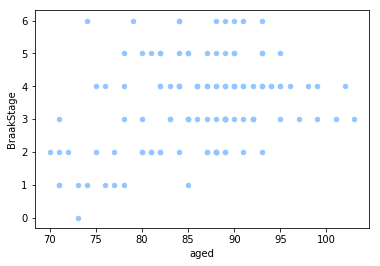

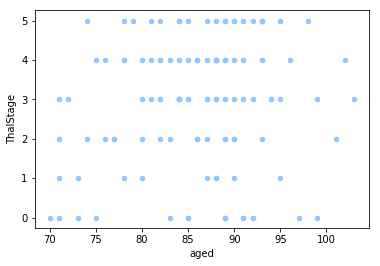

In [5]:
# Create Seperate dataframes by centre

# Cambridge
# Clinical dataset
clinCambridge = clin['Case'].str.startswith('RH')
clinCambridge = clin[clinCambridge].copy()

# Pathological dataset
pathoCambridge = patho['Case'].str.startswith('RH')
pathoCambridge = patho[pathoCambridge].copy()

short = pd.to_numeric(clinCambridge.loc[:,'Case'].str[2:])
clinCambridge.loc[:,'Case'] = short
clinCambridge.sort_values(by=['Case'], inplace = True)
clinCambridge.head()

short = pathoCambridge.loc[:,'Case'].str[2:]
pathoCambridge.loc[:,'Case'] = pd.to_numeric(short)
pathoCambridge.sort_values(by=['Case'],inplace =True)

cambridge = pathoCambridge.merge(clinCambridge, how = 'left', on = ['Case'])
cambridge.head()

cambridge.plot(x = "aged", y = "BraakStage",kind = "scatter")
cambridge.plot(x = "aged", y = "ThalStage",kind = "scatter")
# cambridge.head()

In [6]:
# Newcastle
clinNewcastle = clin['Case'].str.startswith('NA')
clinNewcastle = clin[clinNewcastle].copy()

pathoNewcastle = patho['Case'].str.startswith('NA')
pathoNewcastle = patho[pathoNewcastle].copy()

short = pd.to_numeric(clinNewcastle.loc[:,'Case'].str[2:].str.replace("/",""))
clinNewcastle.loc[:,'Case'] = short
clinNewcastle.sort_values(by=['Case'], inplace = True)

short = pathoNewcastle.loc[:,'Case'].str[2:].str.replace("/","")
pathoNewcastle.loc[:,'Case'] = pd.to_numeric(short)
pathoNewcastle.sort_values(by=['Case'],inplace =True)

newcastle = pathoNewcastle.merge(clinNewcastle, how = 'left', on = ['Case'])
# newcastle.head()

In [7]:
# Creates master data set containing both cambridge and newcastle data sets
master = cambridge.append(newcastle).copy()
master = master[(master[['dem_nver4']] != 0).all(axis=1)]

# add age category

def ageCat(row):
    if row["aged"] != row["aged"]:
        return row["aged"]
    if row["aged"] < 80:
        return "young"
    elif row["aged"] >= 80 and row["aged"] <= 89:
        return "mid"
    else:
        return "old"

def ageCatNum(row):
    if row["aged"] != row["aged"]:
        return row["aged"]
    if row["aged"] < 80:
        return 0
    elif row["aged"] >= 80 and row["aged"] <= 89:
        return 1
    else:
        return 2

master["ageCat"] = master.apply(ageCat,axis=1)
master["ageCatNum"] = master.apply(ageCatNum,axis=1)

# master[["aged","ageCat"]].head()





The first step is the establish realtionships between two variables in order to buld a univariate model. The following figures show the relationship between Braak or Thal Stages with age.

Hypothesis – 
1. Thal Abeta stage relates to dementia. 

2. Thal is more finely graded than the CERAD plaque scores, so 
Thal stage is better predictor of dementia than CERAD plaque density.

a. Univariate – how does Thal stage relate to dementia. Nos of demented vs non-demented for each stage, odds ratio.

b. Multi- how does it behave in a log regression model of dementia with BNE neuropil thread stage, and CERAD plaque score – is Thal better than CERAD? Also include CAA. Is it better than neuropil thread score.

<Figure size 432x288 with 0 Axes>

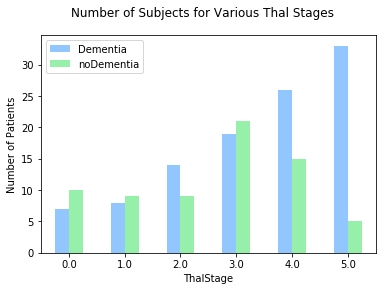

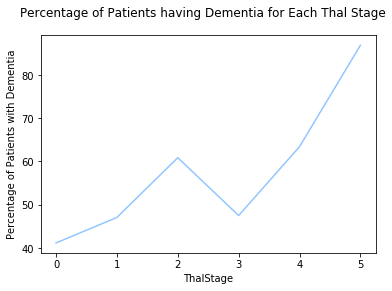

,ThalStage,Dementia,noDementia
0,0.0,7,10
1,1.0,8,9
2,2.0,14,9
3,3.0,19,21
4,4.0,26,15


In [8]:
# Does Thal Abets stage relate to dementia?

# Visualisation for univariate question

thalBar = frequencyChart(master,'ThalStage','dem_nver4')
thalBar.head()

ratios = []
ratios = ((thalBar['Dementia']/(thalBar['noDementia'] + thalBar['Dementia'])*100))

plt.figure()

thalBar.head()
thalBar.plot.bar(x = "ThalStage",rot = 0)
plt.suptitle("Number of Subjects for Various Thal Stages" )
plt.ylabel('Number of Patients')

plt.figure()
ratios.plot()
plt.suptitle("Percentage of Patients having Dementia for Each Thal Stage" )
plt.xlabel('ThalStage')
plt.ylabel('Percentage of Patients with Dementia')

plt.show()
thalBar.head()

I thought this was as intersting relationship so investigated similar relationships as shown below for BrainNet, Braak and CERAD staging. 

<Figure size 432x288 with 0 Axes>

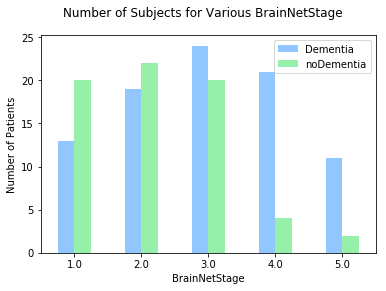

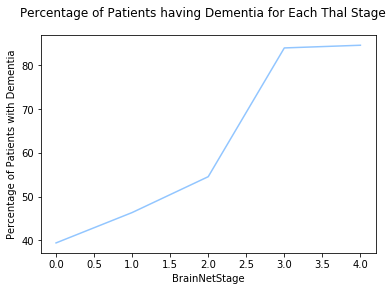

In [9]:
# set up dataframe for BNE stage and dementia diagnosis

BNEBar = frequencyChart(master,'BrainNetStage','dem_nver4')

# visualisation for brain net

ratios = []
ratios = ((BNEBar['Dementia']/(BNEBar['noDementia'] + BNEBar['Dementia']))*100)

# plotting
plt.figure()
BNEBar.head()
BNEBar.plot.bar(x = "BrainNetStage",rot = 0)

plt.suptitle("Number of Subjects for Various BrainNetStage" )
plt.ylabel('Number of Patients')

plt.figure()
ratios.plot()
plt.suptitle("Percentage of Patients having Dementia for Each Thal Stage" )
plt.xlabel('BrainNetStage')
plt.ylabel('Percentage of Patients with Dementia')

plt.show()

<Figure size 432x288 with 0 Axes>

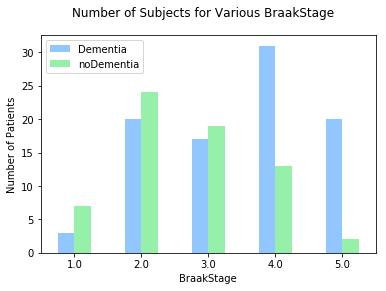

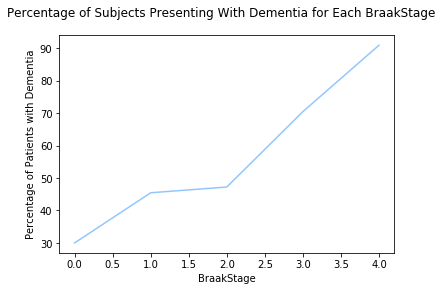

In [10]:
# set up dataframe for Braak stage and dementia diagnosis

braakBar = frequencyChart(master,'BraakStage','dem_nver4')

# visualisation for brain net

ratios = []
ratios = (braakBar['Dementia']/(braakBar['noDementia'] + braakBar['Dementia'])*100)

# plotting
plt.figure()
braakBar.plot.bar(x = "BraakStage",rot = 0)
plt.suptitle("Number of Subjects for Various BraakStage" )
plt.ylabel('Number of Patients')

plt.figure()
ratios.plot()
plt.suptitle("Percentage of Subjects Presenting With Dementia for Each BraakStage" )
plt.xlabel('BraakStage')
plt.ylabel('Percentage of Patients with Dementia')

plt.show()

0    46.551724
1    54.838710
2    74.193548
3    91.304348
dtype: float64


<Figure size 432x288 with 0 Axes>

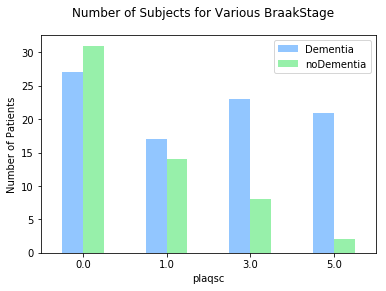

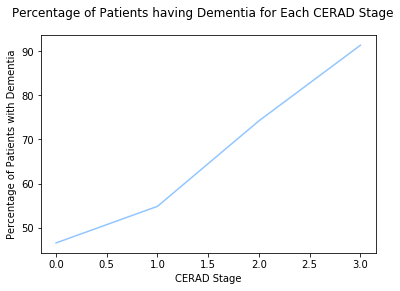

In [11]:
# plaqsc = cerad scores

# set up dataframe for Braak stage and dementia diagnosis

ceradBar = frequencyChart(master,'plaqsc','dem_nver4')

# visualisation for brain net

ratios = []
ratios = ((ceradBar['Dementia']/(ceradBar['noDementia'] + ceradBar['Dementia']))*100)

# plotting
plt.figure()
ceradBar.plot.bar(x = "plaqsc", rot = 0)
plt.suptitle("Number of Subjects for Various BraakStage" )
plt.ylabel('Number of Patients')

plt.figure()
print(ratios)
plt.plot(ratios)
plt.suptitle("Percentage of Patients having Dementia for Each CERAD Stage" )
plt.xlabel('CERAD Stage')
plt.ylabel('Percentage of Patients with Dementia')

plt.show()
# print(ratios)
# print(ceradBar)

0    38.095238
1    78.787879
2    57.352941
dtype: float64


<Figure size 432x288 with 0 Axes>

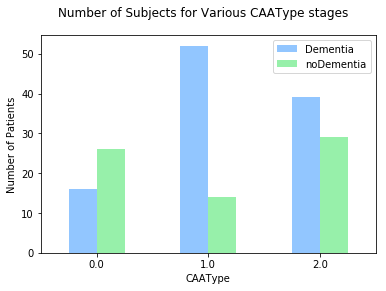

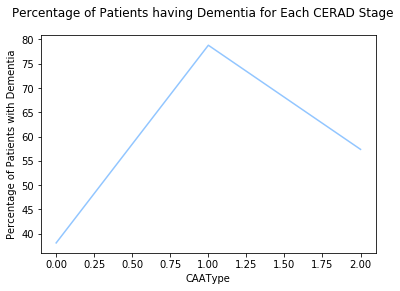

In [12]:
# caa type

# set up dataframe for caa stage and dementia diagnosis
master.head()
caaBar = frequencyChart(master,'CAAType','dem_nver4')

# visualisation for brain net

ratios = []
ratios = ((caaBar['Dementia']/(caaBar['noDementia'] + caaBar['Dementia']))*100)

# plotting
plt.figure()
caaBar.plot.bar(x = "CAAType", rot = 0)
plt.suptitle("Number of Subjects for Various CAAType stages" )
plt.ylabel('Number of Patients')

plt.figure()
print(ratios)
plt.plot(ratios)
plt.suptitle("Percentage of Patients having Dementia for Each CERAD Stage" )
plt.xlabel('CAAType')
plt.ylabel('Percentage of Patients with Dementia')

plt.show()
# print(ratios)
# print(ceradBar)


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Relationship between brain weight and age')

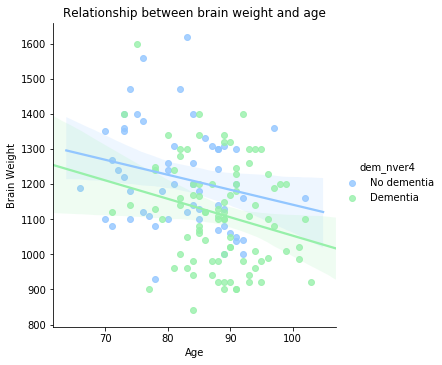

In [13]:
#relationship between brain weight and age
ageComparisons = master[['aged','brainwgt','ThalStage','dem_nver4']]
ageComparisons = ageComparisons.drop(ageComparisons[ageComparisons.brainwgt<10].index)
ageComparisons = ageComparisons.dropna()
ageComparisons.head()

# plt.figure()
# ageComparisons.plot.scatter(x = 'aged', y  = 'brainwgt')
# plt.show()

#should probably add regression and examine anamlous results at bottom of graph

ax = sns.lmplot(x="aged", y="brainwgt", data=ageComparisons, hue = "dem_nver4")
plt.xlabel("Age")
plt.ylabel("Brain Weight")
plt.title("Relationship between brain weight and age") # You can comment this line out if you don't need title


,partClassification,dem_nver4
0,PART-Probable,No dementia
1,Tau Pathology,Dementia
2,Control,Dementia
3,Control,No dementia
4,PART-Definite,No dementia
5,PART-Probable,No dementia
6,Control,Dementia
7,Tau Pathology,No dementia
8,Control,Dementia
9,PART-Probable,Dementia


,partClassification,Dementia,noDementia
0,Control,42.0,38
1,PART-Definite,7.0,9
2,PART-Probable,22.0,16
3,Tau Pathology,36.0,2


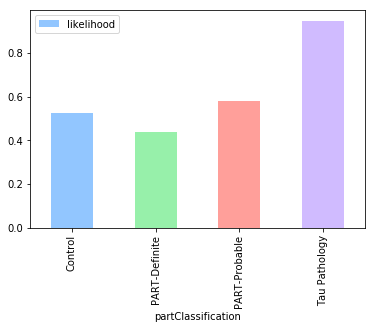

In [14]:
# part reclassification by Braak
part = master[['Case','BraakStage','ThalStage','dem_nver4']].copy()
part = part[(part[['dem_nver4']] != 0).all(axis=1)]
def partClassifier(c):
    c = c.dropna()
    if c['BraakStage'] == 0:
#         print("trig")
        return 'No Pathology'

    elif c['BraakStage'] <= 4 and c['BraakStage'] >= 1 and  c['ThalStage'] == 0:
        return 'PART-Definite'

    elif c['BraakStage'] <= 4 and c['BraakStage'] >= 1 and  c['ThalStage'] >= 1 and c['ThalStage'] <= 2:    
        return 'PART-Probable'

    elif c['BraakStage'] >= 5:
        return 'Tau Pathology'

    elif c['BraakStage'] <= 4 and c['BraakStage'] >= 1 and  c['ThalStage'] >= 2 and c['ThalStage'] <= 5:    
        return 'Control'

    else:
        return 'Undefined'

part['partClassification'] = part.apply(partClassifier, axis=1)
display(part[['partClassification','dem_nver4']])

partFreq = frequencyChart(part,'partClassification','dem_nver4')
display(partFreq)

ratios = []
ratios = (partFreq['Dementia']/(partFreq['noDementia'] + partFreq['Dementia']))
partFreq['likelihood'] = ratios
# display(partFreq)

partFreq.plot(x = 'partClassification',y = 'likelihood', kind = 'bar')

# partFreq.plot(kind = 'Bar', xticks = partFreq.partClassification)

# ax = partFreq.plot()
# ax.set_xticks(partFreq.index) 
# ax.set_xticklabels(partFreq.partClassification, rotation=90)

plt.show()

# add title and update onto doc

,ThalStage,young,mid,old
0,0.0,4,8,7
1,1.0,6,6,5
2,2.0,8,9,6
3,3.0,7,23,14
4,4.0,9,23,9
5,5.0,4,14,22


<Figure size 432x288 with 0 Axes>

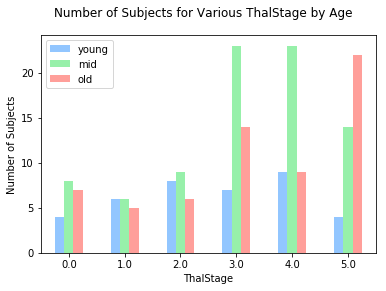

In [15]:
#interaction between age and thal score

ageThal = ageFreqChart(master,'ThalStage','ageCat')

plt.figure()
ageThal.plot.bar(x = "ThalStage", rot = 0)
plt.suptitle("Number of Subjects for Various ThalStage by Age" )
plt.ylabel('Number of Subjects')

display(ageThal)

,plaqsc,young,mid,old
0,0.0,18,26,15
1,1.0,4,15,14
2,3.0,8,12,11
3,5.0,6,7,11


<Figure size 432x288 with 0 Axes>

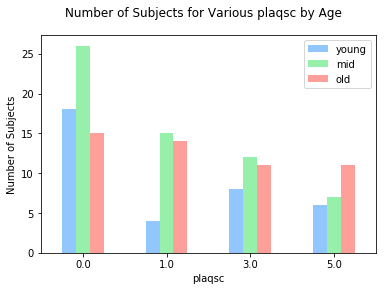

In [16]:
#interaction between age and thal score

agePlaqsc = ageFreqChart(master,'plaqsc','ageCat')

agePlaqsc = ageFreqChart(master,'plaqsc','ageCat')

plt.figure()
agePlaqsc.plot.bar(x = "plaqsc", rot = 0)
plt.suptitle("Number of Subjects for Various plaqsc by Age" )
plt.ylabel('Number of Subjects')

ageThal.head()

display(agePlaqsc)

I then built a classifiers so as to assess whether thal was a better in fact a better predictor of dementia than cerad.

In [17]:
# agePart = ageFreqChart(master,'plaqsc','ageCat')
partAge = master[['Case','BraakStage','ThalStage','dem_nver4','ageCat']].copy()

partAge['partClassification'] = part.apply(partClassifier, axis=1)
partAge.iloc[:,1:2].head() #needs fixing!!

partAge.head()

# plt.figure()
# partAge.plot.bar(x = "partClassification", rot = 0)
# plt.suptitle("Number of Subjects for Various part by Age" )
# plt.ylabel('Number of Subjects')


,Case,BraakStage,ThalStage,dem_nver4,ageCat,partClassification
0,1,1.0,2.0,No dementia,young,PART-Probable
1,2,5.0,5.0,Dementia,old,Tau Pathology
2,3,2.0,3.0,Dementia,mid,Control
3,4,3.0,3.0,No dementia,mid,Control
4,5,2.0,0.0,No dementia,young,PART-Definite


In [18]:
from sklearn.model_selection import cross_val_score

# Thal classifier
thalClass = master[['Case','ThalStage','dem_nver4']]
thalClass = pd.get_dummies(thalClass)
thalClass.drop(thalClass.columns[len(thalClass.columns)-1], axis=1, inplace=True)
thalClass.head()


,Case,ThalStage,dem_nver4_Dementia
0,1,2.0,0
1,2,5.0,1
2,3,3.0,1
3,4,3.0,0
4,5,0.0,0


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(thalClass[['ThalStage']], thalClass[['dem_nver4_Dementia']], random_state=0)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

logreg = LogisticRegression()

X_train,y_train = resample(X_train,y_train ,replace=True,  random_state=1)

logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

scores = cross_val_score(logreg, thalClass[['ThalStage']],  np.ravel(thalClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))




Accuracy of Logistic regression classifier on training set: 0.67
Accuracy of Logistic regression classifier on test set: 0.57
Accuracy: 0.60 (+/- 0.03)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# Cerad classifier
ceradClass = master[['Case','plaqsc','dem_nver4']]
ceradClass = pd.get_dummies(ceradClass)
ceradClass.drop(ceradClass.columns[len(ceradClass.columns)-1], axis=1, inplace=True)
ceradClass.dropna(axis=0, how='any',inplace = True)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(ceradClass[['plaqsc']], ceradClass[['dem_nver4_Dementia']], random_state=0)

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
#print(ceradClass.shape)
#print(dem_nver4.shape)
scores = cross_val_score(logreg, ceradClass[['plaqsc']],  np.ravel(ceradClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of Logistic regression classifier on training set: 0.63
Accuracy of Logistic regression classifier on test set: 0.65
Accuracy: 0.63 (+/- 0.13)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
# CAA classifier
caaClass = master[['Case','CAAType','dem_nver4']]
caaClass = pd.get_dummies(caaClass)
caaClass.drop(caaClass.columns[len(caaClass.columns)-1], axis=1, inplace=True)
caaClass.dropna(axis=0, how='any',inplace = True)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(caaClass[['CAAType']], caaClass[['dem_nver4_Dementia']], random_state=0)



In [26]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
#print(caaClass.shape)
#print(dem_nver4.shape)
scores = cross_val_score(logreg, caaClass[['CAAType']],  np.ravel(caaClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))





Accuracy of Logistic regression classifier on training set: 0.65
Accuracy of Logistic regression classifier on test set: 0.66
Accuracy: 0.61 (+/- 0.04)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
# braak classifier
braakClass = master[['Case','BraakStage','dem_nver4']]
braakClass = pd.get_dummies(braakClass)
braakClass.drop(braakClass.columns[len(braakClass.columns)-1], axis=1, inplace=True)
braakClass.dropna(axis=0, how='any',inplace = True)



In [28]:
X_train, X_test, y_train, y_test = train_test_split(braakClass[['BraakStage']], braakClass[['dem_nver4_Dementia']], random_state=0)



In [29]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

#print(braakClass.shape)
#print(dem_nver4.shape)
scores = cross_val_score(logreg, braakClass[['BraakStage']],  np.ravel(braakClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))





Accuracy of Logistic regression classifier on training set: 0.64
Accuracy of Logistic regression classifier on test set: 0.74
Accuracy: 0.67 (+/- 0.09)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
# adding columns for highest neuritic plaq sc in 
# 4 cortical areas and mean




From these results it seems that there is no significnt change in accuracy.

In [31]:
# Multivar classifier
multiClass = master[['Case','ThalStage', 'BraakStage','plaqsc','CAAType','ageCat','brainwgt','dem_nver4']]
multiClass = pd.get_dummies(multiClass)
multiClass.drop(multiClass.columns[len(multiClass.columns)-1], axis=1, inplace=True)
multiClass.dropna(axis=0, how='any',inplace = True)

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# #add one hot encoding of age here 
# leAgeCat = LabelEncoder()
# multiClass['ageCat_encoded'] = leAgeCat.fit_transform(multiClass.ageCat)
multiClass.head()


,Case,ThalStage,BraakStage,plaqsc,CAAType,brainwgt,ageCat_mid,ageCat_old,ageCat_young,dem_nver4_Dementia
0,1,2.0,1.0,0.0,0.0,1100.0,0,0,1,0
1,2,5.0,5.0,5.0,1.0,980.0,0,1,0,1
2,3,3.0,2.0,1.0,2.0,1000.0,1,0,0,1
3,4,3.0,3.0,0.0,0.0,1100.0,1,0,0,0
4,5,0.0,2.0,0.0,0.0,1100.0,0,0,1,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(multiClass[['ThalStage','BraakStage','plaqsc','CAAType','ageCat_mid','ageCat_old', 'ageCat_young']], multiClass[['dem_nver4_Dementia']], random_state=0)



In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, np.ravel(y_train))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

# multiClass.iloc[:,1:8].head()


scores = cross_val_score(logreg, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of Logistic regression classifier on training set: 0.67
Accuracy of Logistic regression classifier on test set: 0.62
Accuracy: 0.70 (+/- 0.19)


In [34]:
# bootstrap validation
from sklearn.utils import resample

# line for seeing difference bootsrapping makes to accuracy
# X_train, X_test, y_train, y_test = train_test_split(multiClass[['ThalStage','BraakStage','plaqsc','CAAType','ageCat_mid','ageCat_old', 'ageCat_young']], multiClass[['dem_nver4_Dementia']], random_state=0)

# boot = resample(multiClass[['ThalStage','BraakStage','plaqsc','CAAType','ageCat_mid','ageCat_old', 'ageCat_young']],multiClass[['dem_nver4_Dementia']] ,replace=True,  random_state=1)
# print('Bootstrap Sample: %s' % boot)
# oob = [x for x in data if x not in boot]
# print('OOB Sample: %s' % oob)

# X_train,y_train = resample(X_train,y_train ,replace=True,  random_state=1)

logreg = LogisticRegression()
logreg.fit(X_train, np.ravel(y_train))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

coef = logreg.coef_
print(coef)


scores = cross_val_score(logreg, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of Logistic regression classifier on training set: 0.62
[[-0.0995213   0.35504235  0.41658543 -0.16466083  0.17726214 -0.02251662
  -0.99726183]]
Accuracy: 0.70 (+/- 0.19)


I then investigated a variety of clasification algorithms as shown below.

In [35]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, np.ravel(y_train))
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

scores = cross_val_score(clf, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#multiClass.head()

Accuracy of Decision Tree classifier on training set: 0.91
Accuracy of Decision Tree classifier on test set: 0.69
Accuracy: 0.73 (+/- 0.17)


In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, np.ravel(y_train))
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

scores = cross_val_score(knn, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of K-NN classifier on training set: 0.77
Accuracy of K-NN classifier on test set: 0.59
Accuracy: 0.54 (+/- 0.07)


In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, np.ravel(y_train))
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

scores = cross_val_score(lda, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy of LDA classifier on training set: 0.68
Accuracy of LDA classifier on test set: 0.62
Accuracy: 0.73 (+/- 0.19)


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [38]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, np.ravel(y_train))
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))


scores = cross_val_score(gnb, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy of GNB classifier on training set: 0.68
Accuracy of GNB classifier on test set: 0.62
Accuracy: 0.68 (+/- 0.16)


In [39]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, np.ravel(y_train))
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

scores = cross_val_score(svm, multiClass.iloc[:,1:9],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of SVM classifier on training set: 0.80
Accuracy of SVM classifier on test set: 0.59
Accuracy: 0.62 (+/- 0.09)


It looks like the LDA classifier gives a narrowly better performance.

I then wanted to investigate the relationship between these metrics so as to inform a multivariate model.

In [40]:
#compare thal to plaqsc

logreg = LogisticRegression()
scores = cross_val_score(logreg, multiClass[['ThalStage','BraakStage','CAAType','ageCat_mid','ageCat_old', 'ageCat_young']],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=10)
print("Accuracy of logistic regression with Thal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

logreg = LogisticRegression()
scores = cross_val_score(logreg, multiClass[['plaqsc','BraakStage','CAAType','ageCat_mid','ageCat_old', 'ageCat_young']],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=10)
print("Accuracy  of logistic regression with Plaque score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of logistic regression with Thal: 0.69 (+/- 0.19)
Accuracy  of logistic regression with Plaque score: 0.68 (+/- 0.22)


Index(['ThalStage', 'BraakStage', 'Frequency', 'Demented', 'likelihood'], dtype='object')


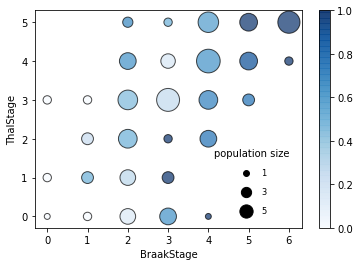

In [41]:
thalVBraak = master.groupby(["ThalStage", "BraakStage"]).size().reset_index(name="Frequency")
thalVBraak2 = master[master['dem_nver4'] == 'Dementia'].groupby(["ThalStage", "BraakStage"]).size()

thalVBraak3 = thalVBraak.merge(thalVBraak2.to_frame(), left_on=['ThalStage','BraakStage'], right_index=True)
thalVBraak3 = pd.merge(thalVBraak,thalVBraak3,how='outer')
thalVBraak3 = thalVBraak3.fillna(0)
thalVBraak3.rename(columns={0: "Demented"},inplace = True)
thalVBraak3['likelihood'] = thalVBraak3['Demented']/thalVBraak3['Frequency']
print(thalVBraak3.columns)

points = plt.scatter(y = thalVBraak3["ThalStage"],x = thalVBraak3["BraakStage"], s=thalVBraak["Frequency"]*35,
                     c= thalVBraak3["likelihood"],
                     cmap="Blues",alpha = 0.7, edgecolor='black')
plt.colorbar(points)


plt.ylabel('ThalStage')
plt.xlabel('BraakStage')

pws = [ 1, 3, 5]
for pw in pws:
    plt.scatter([], [], s=pw*35, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[1:], l[1:], labelspacing=1.2, title="population size",
           borderpad=1,frameon=False, framealpha=0.6,
           edgecolor="k", facecolor="w", fontsize = 'small', loc = 'lower right')
plt.savefig("test.svg", format="svg")

plt.show()

In [42]:
# update figures file (no code)
# Cross validate ml tests
# sensitivity analysis
# is there an independent validation set?
# learning curve (change ration between training set and test set)
# take out final test set example?

# figures
# can the reader understand it in 30s?
# broad audience should be able to understand
# should give comprehensive overview
# make part more clear (add boxes)

# further
# k-means clustering

# Done
# Ask about bench mark for classification
#    bench mark is brain weight and age
%qtconsole

# 16/11/18
# change cross val to leave one out or k = 5
# check for balance in training set


# try using labels rather than encoding
# test linearity between covariates and response


# do these factors actually accumulate over time? - try rank hot encoding vs one hot encoding
# change age plaq bar chart to proportional representation for ecah thal score
# include reference to question answered in plots
# added lines to part plot


# emphasis 
# sensitivity analysis

#     bootsrap other moterhdso to check feature importance
#     produce tables instead of figures for every question
# add part to multivariate classifier


# update figures in google doc for steeve (over weekend)
# on labelling figure wrt questions (make prioirty)
# which factors have most influence, bootstrap and sensitivity analysis
# can we identify an individual who a doctor would be likely to misdiagnose, an outlier case
#     asked dennis for this
# update master csv with features we used
# replace braak and thal score by age rubbish plot with histrgram


# add caa univatiate classifier (not sure if we have this anymore)
# part is combiniation of braak and thal so try adding wihtout braak and thal

# 3c) visualisation of part age and demential maybe like dot scatter grant figure, age my size?
# age continuous, part categorical and binary case
#    beware of overlaying dots

# may be worth including just age and brain weight as benchmark

# no longer neccesarry
# Do apoe questions, single sample should be labelled apoe (genetic mutation)
# add figures into paper google doc

# check
# caa type should probably be encoded as one hot

# focus on creating plots answering to message
# don't worry about size, colours, overlaying things etc.

# make sure that you use odf vector as in grant figure thing

# done

# try bootstrap to determine better parameters on training set

# 7/12/18
# deadline : 10/12/18
# univariate models results clean table - done
# for multivariate refer to beltrachini paper, sort table by adding on various features
# add all tables to figures - mostly done
# export new pdf to give access to vectors -done
# sen email to confirm submittal to drive


# 13/1/18
# resample without replacement (to increase number of fold)
# re configure 1/3 validation, do about 1000 times

# redo table so each column uses 5 features (drop one feature each time)
# add accuracy calculation in methods
# email with any issues (get this done today and it will be over with)



In [43]:
# ipython nbconvert --to pdf mynotebook.ipynb
# multiClass.head()

In [44]:
# feature selection experiments

# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasets
# dataset = datasets.load_iris()
# dataset = multiClass[['ThalStage','BraakStage','CAAType','ageCat_mid','ageCat_old', 'ageCat_young']]
# create a base classifier used to evaluate a subset of attributes

model = LogisticRegression()
# create the RFE model and select 3 attributes
# rfe = RFE(model, 2)
# rfe = rfe.fit( master[['ThalStage','BraakStage','CAAType','ageCatNum']], multiClass[['dem_nver4_Dementia']])

X = multiClass.loc[:, multiClass.columns != 'dem_nver4_Dementia']
X.head()

rfe = RFE(model, 6)
rfe = rfe.fit( X , multiClass[['dem_nver4_Dementia']])

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

master[['ThalStage','BraakStage','CAAType','ageCatNum']].head()




[False  True  True  True False False  True  True  True]
[4 1 1 1 2 3 1 1 1]


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,ThalStage,BraakStage,CAAType,ageCatNum
0,2.0,1.0,0.0,0.0
1,5.0,5.0,1.0,2.0
2,3.0,2.0,2.0,1.0
3,3.0,3.0,0.0,1.0
4,0.0,2.0,0.0,0.0


In [69]:
# Multivar classifier
multiClass = master[['Case','ThalStage', 'BraakStage','plaqsc','CAAType','ageCat','brainwgt','dem_nver4']].copy()
multiClass = pd.get_dummies(multiClass)
multiClass.drop(multiClass.columns[len(multiClass.columns)-1], axis=1, inplace=True)
multiClass.dropna(axis=0, how='any',inplace = True)

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# #add one hot encoding of age here 
# leAgeCat = LabelEncoder()
# multiClass['ageCat_encoded'] = leAgeCat.fit_transform(multiClass.ageCat)
multiClass.head()

,Case,ThalStage,BraakStage,plaqsc,CAAType,brainwgt,ageCat_mid,ageCat_old,ageCat_young,dem_nver4_Dementia
0,1,2.0,1.0,0.0,0.0,1100.0,0,0,1,0
1,2,5.0,5.0,5.0,1.0,980.0,0,1,0,1
2,3,3.0,2.0,1.0,2.0,1000.0,1,0,0,1
3,4,3.0,3.0,0.0,0.0,1100.0,1,0,0,0
4,5,0.0,2.0,0.0,0.0,1100.0,0,0,1,0


In [87]:
# Multivar classifier
multiClass2 = master[['Case','ThalStage', 'BraakStage','plaqsc','CAAAreas','ageCat','brainwgt','dem_nver4']].copy()
multiClass2 = pd.get_dummies(multiClass2)
multiClass2.drop(multiClass2.columns[len(multiClass2.columns)-1], axis=1, inplace=True)
multiClass2.dropna(axis=0, how='any',inplace = True)

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# #add one hot encoding of age here 
# leAgeCat = LabelEncoder()
# multiClass['ageCat_encoded'] = leAgeCat.fit_transform(multiClass.ageCat)
multiClass2.head()

# 

,Case,ThalStage,BraakStage,plaqsc,CAAAreas,brainwgt,ageCat_mid,ageCat_old,ageCat_young,dem_nver4_Dementia
0,1,2.0,1.0,0.0,0.0,1100.0,0,0,1,0
1,2,5.0,5.0,5.0,6.0,980.0,0,1,0,1
2,3,3.0,2.0,1.0,1.0,1000.0,1,0,0,1
3,4,3.0,3.0,0.0,0.0,1100.0,1,0,0,0
4,5,0.0,2.0,0.0,0.0,1100.0,0,0,1,0


In [46]:
X_train, X_test, y_train, y_test = train_test_split(multiClass[['ThalStage']], multiClass[['dem_nver4_Dementia']], random_state=0)

multiClass.iloc[:,1].head()


0    2.0
1    5.0
2    3.0
3    3.0
4    0.0
Name: ThalStage, dtype: float64

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, np.ravel(y_train))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

# multiClass.iloc[:,1:8].head()


# scores = cross_val_score(logreg, multiClass[['ThalStage','BraakStage','plaqsc','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young']],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)


scores = cross_val_score(logreg, multiClass[['ThalStage','plaqsc','BraakStage','CAAType']],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy of Logistic regression classifier on training set: 0.59
Accuracy of Logistic regression classifier on test set: 0.59
Accuracy: 0.65 (+/- 0.11)


In [48]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, np.ravel(y_train))
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

scores = cross_val_score(clf, multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young']],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))




Accuracy of Decision Tree classifier on training set: 0.66
Accuracy of Decision Tree classifier on test set: 0.66
Accuracy: 0.71 (+/- 0.13)


In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, np.ravel(y_train))
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

scores = cross_val_score(lda, multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young']],  np.ravel(multiClass[['dem_nver4_Dementia']]), cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))




Accuracy of LDA classifier on training set: 0.59
Accuracy of LDA classifier on test set: 0.59
Accuracy: 0.73 (+/- 0.19)


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [85]:
multiClass.head()

multiClass2 = multiClass.copy()
# multiClass.drop()

# multiClass.head()
multiClass2.head()


,Case,ThalStage,BraakStage,plaqsc,CAAType,brainwgt,ageCat_mid,ageCat_old,ageCat_young,dem_nver4_Dementia
0,1,2.0,1.0,0.0,0.0,1100.0,0,0,1,0
1,2,5.0,5.0,5.0,1.0,980.0,0,1,0,1
2,3,3.0,2.0,1.0,2.0,1000.0,1,0,0,1
3,4,3.0,3.0,0.0,0.0,1100.0,1,0,0,0
4,5,0.0,2.0,0.0,0.0,1100.0,0,0,1,0


In [94]:
# implementing bootstrap resampling 1000 times without replacement
data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young','dem_nver4_Dementia']]
# data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','dem_nver4_Dementia']]

data1 = multiClass2[['ThalStage','plaqsc','CAAAreas','BraakStage','CAAAreas','brainwgt','ageCat_mid','ageCat_old','ageCat_young','dem_nver4_Dementia']]

features = 4
acc = []
var = []
bootstraps = 1000

sumStats = []

for i in range(features):
    data = data1.copy()
    
    
#     for multivariate
      
#     data = data1.drop(data.columns[i],axis=1)
#     data = data1.drop(data.columns[4:8],axis=1)

#     data = data.drop(data.columns[0:3],axis=1)
    
#     for univariate
    data = data1.drop(data.columns[0:4],axis=1)
    data.insert(0,data1.columns[i],data1[data1.columns[i]])
    data = data.drop(data.columns[1:5],axis=1)

#     data2 = data[[data.columns[4]]]
#     data3 = data[['dem_nver4_Dementia']]
    
#     data = pd.merge(data2,data3, left_index=True,right_index=True)
    display(data.head(0))

    for i in range(bootstraps):
        boot = resample(data.copy(), replace=True, n_samples=90)
        oob = data.copy().drop(data.index[[boot.index]])

        X_train = boot.loc[:, boot.columns != 'dem_nver4_Dementia']
        Y_train = boot[['dem_nver4_Dementia']]

        X_test = oob.loc[:, boot.columns != 'dem_nver4_Dementia']
        Y_test = oob[['dem_nver4_Dementia']]

        logreg = LogisticRegression()
        logreg.fit(X_train, np.ravel(Y_train))

        sumStats.append((logreg.score(X_train, Y_train),logreg.score(X_test, Y_test)))

    acc.append([sum(y)/len(y) for y in zip(*sumStats)])
    var.append([np.var([i[0] for i in sumStats]),np.var([i[1] for i in sumStats])])


# 

,ThalStage,dem_nver4_Dementia


/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:2095: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,plaqsc,dem_nver4_Dementia


,BraakStage,dem_nver4_Dementia


,CAAAreas,dem_nver4_Dementia


In [ ]:
data[[data.columns[4]]]

In [95]:
display(acc)
display(var)

[[0.6397777777777788, 0.5935664245562867],
 [0.650300000000002, 0.6078517597234581],
 [0.6582962962963007, 0.6186280405544382],
 [0.6619805555555579, 0.6222376753563619]]

[[0.0027429135802469135, 0.003985897865435731],
 [0.0024962062962962965, 0.004638883723975695],
 [0.0025671385459533607, 0.004541348428016499],
 [0.002567824313271605, 0.004743297694246561]]

In [ ]:
print("Mean accuracy of training and test data")
[sum(y)/len(y) for y in zip(*sumStats)]

In [ ]:
print("Variance of training and test data")
[np.var([i[0] for i in sumStats]),np.var([i[1] for i in sumStats])]

In [ ]:
boot.index

In [ ]:
data = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young','dem_nver4_Dementia']]


data1 = data.copy()
# data1 = data1.drop(data1.columns[i],axis=1)
data1.head()

# 

In [ ]:
data1.columns[2]

In [ ]:
print(list(data1.head()))

In [ ]:
for i in range(features):
    data = data1.copy()
    data = data.drop(data.columns[i],axis=1)
    display(data.head(0))

In [ ]:
i = 3
data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young','dem_nver4_Dementia']]
data = data1.copy()
data = data.drop(data.columns[0:4],axis=1)
data.insert(0,data1.columns[i],data1[data1.columns[i]])
data.head()


# 

In [ ]:
data1.columns[i]

In [ ]:

# implementing bootstrap resampling 1000 times without replacement
data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young','dem_nver4_Dementia']]
# data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','dem_nver4_Dementia']]


features = 4
acc = []
var = []
bootstraps = 1000

sumStats = []

for i in range(features):
    data = data1.copy()
    
    
#     for multivariate
#     data = data1.drop(data.columns[i],axis=1)

    data = data1.drop(data.columns[4:8],axis=1)
    
#     data = data.drop(data.columns[0:3],axis=1)
    
#     for univariate
#     data = data1.drop(data.columns[0:4],axis=1)
#     data.insert(0,data1.columns[i],data1[data1.columns[i]])
#     data = data.drop(data.columns[1:5],axis=1)
    
    display(data.head(0))

    for i in range(bootstraps):
        boot = resample(data.copy(), replace=True, n_samples=90)
        oob = data.copy().drop(data.index[[boot.index]])

        X_train = boot.loc[:, boot.columns != 'dem_nver4_Dementia']
        Y_train = boot[['dem_nver4_Dementia']]

        X_test = oob.loc[:, boot.columns != 'dem_nver4_Dementia']
        Y_test = oob[['dem_nver4_Dementia']]

        clf = DecisionTreeClassifier()
        clf.fit(X_train, np.ravel(Y_train))

        sumStats.append((clf.score(X_train, Y_train),clf.score(X_test, Y_test)))

    acc.append([sum(y)/len(y) for y in zip(*sumStats)])
    var.append([np.var([i[0] for i in sumStats]),np.var([i[1] for i in sumStats])])

display(acc)
display(var)
# 

In [ ]:
# implementing bootstrap resampling 1000 times without replacement
data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','brainwgt','ageCat_mid','ageCat_old','ageCat_young','dem_nver4_Dementia']]
# data1 = multiClass[['ThalStage','plaqsc','BraakStage','CAAType','dem_nver4_Dementia']]


features = 4
acc = []
var = []
bootstraps = 1000

sumStats = []

for i in range(features):
    data = data1.copy()
    
    
#     for multivariate
#     data = data1.drop(data.columns[i],axis=1)

#      data = data.drop(data.columns[0:3],axis=1)
    
#     for univariate
#     data = data1.drop(data.columns[0:4],axis=1)
#     data.insert(0,data1.columns[i],data1[data1.columns[i]])
#     data = data.drop(data.columns[1:5],axis=1)
    data = data1.drop(data.columns[4:8],axis=1)

    display(data.head(0))

    for i in range(bootstraps):
        boot = resample(data.copy(), replace=True, n_samples=90)
        oob = data.copy().drop(data.index[[boot.index]])

        X_train = boot.loc[:, boot.columns != 'dem_nver4_Dementia']
        Y_train = boot[['dem_nver4_Dementia']]

        X_test = oob.loc[:, boot.columns != 'dem_nver4_Dementia']
        Y_test = oob[['dem_nver4_Dementia']]

        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, np.ravel(Y_train))

        sumStats.append((lda.score(X_train, Y_train),lda.score(X_test, Y_test)))

    acc.append([sum(y)/len(y) for y in zip(*sumStats)])
    var.append([np.var([i[0] for i in sumStats]),np.var([i[1] for i in sumStats])])

display(acc)
display(var)
# 